In [3]:
import os
import sys
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import math
import json
import pandas as pd
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
import numpy as np
from sklearn.neighbors import NearestNeighbors


In [4]:
fname = "./ibadan_EAs_of_interest_v2/shapefile_of_Ibadan_EAs_of_interest_v2.shx"
ib_data = gpd.read_file(fname)
ib_data.shape, ib_data.columns


((378, 8),
 Index(['city', 'ward', 'ea_code', 'EAS', 'Longitude', 'Latitude', 'Settlement',
        'geometry'],
       dtype='object'))

In [5]:
# Convert all variations of 'slum' to 'slum'
ib_data['Settlement'] = ib_data['Settlement'].replace(['Slum', 'slums'], 'slum')
ib_data['Settlement'] = ib_data['Settlement'].replace(['Informal'], 'informal')
ib_data['Settlement'] = ib_data['Settlement'].replace(['Formal'], 'formal')


In [6]:
ib_data_bashorum = ib_data.loc[(ib_data['ward'] == "Bashorun")]
ib_data_bashorum.shape


(85, 8)

In [7]:
ib_data_bashorum.head()


,city,ward,ea_code,EAS,Longitude,Latitude,Settlement,geometry
91,Ibadan,Bashorun,Ba_001,Back of Ibadan Civic Center,3.922842,7.401855,formal,POINT (3.92284 7.40186)
92,Ibadan,Bashorun,Ba_002,Yidi Road,3.923192,7.400557,informal,POINT (3.92319 7.40056)
93,Ibadan,Bashorun,Ba_007,IKOLABA GRAMMAR SCHOOL,3.921463,7.400783,formal,POINT (3.92146 7.40078)
94,Ibadan,Bashorun,Ba_008,Sholotan Street,3.918868,7.410633,formal,POINT (3.91887 7.41063)
95,Ibadan,Bashorun,Ba_010,Ikolaba Central Mosque,3.919921,7.410540,informal,POINT (3.91992 7.41054)


In [8]:
longitudes = ib_data_bashorum['Longitude'].tolist()
latitudes = ib_data_bashorum['Latitude'].tolist()


In [9]:
le.fit(ib_data_bashorum['Settlement'])
labels = le.transform(ib_data_bashorum['Settlement'])


In [10]:
len(labels), len(longitudes), len(latitudes), labels[:5], longitudes[:5], latitudes[:5]


(85,
 85,
 85,
 array([0, 1, 0, 0, 1]),
 [3.922842, 3.923192, 3.921463, 3.918868, 3.919921],
 [7.401855, 7.400557, 7.400783, 7.410633, 7.41054])

In [11]:
checker = []
for label in labels:
    if not label in checker:
        checker.append(label)
checker


[0, 1, 2]

In [77]:

def knn_function(longitudes, latitudes):
    # Sample data: latitudes, longitudes, and corresponding labels
    # Assuming you have your data stored in arrays latitudes, longitudes, and labels

    # Define the number of nearest neighbors to consider
    k_neighbors = 5

    # Initialize NearestNeighbors model
    nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(np.column_stack((longitudes, latitudes)))

    return nbrs


In [75]:
def calculate_knn(knn_function, longitude, latitude):
    # takes the knn function and calculate the k_nearest neighbor for each of the points.
    # returns the neighbor indices and distances of to nearest neighbor
    distances, indices = knn_function.kneighbors([[longitude, latitude]])
    return distances, indices


In [83]:
def neighbor_distance(distances, indices): 
    # taking the full list of distance and indices and excluding the centeroid pointer from them.
    distances = distances[0][1:]
    indices = indices[0][1:]
    return distances, indices


(array([0.00134436, 0.00174666, 0.00653373, 0.00676615]), array([1, 2, 9, 8]))

In [87]:
def extracting_pointer(longitudes = None, latitudes = None, labels = None, indices = neighbor_indices):
    coordinate = [[long, lat, lab] for long, lat, lab in zip(longitudes, latitudes, labels)]
    neighborhood_pointers = [coordinate[x] for x in indices]
    return neighborhood_pointers


[[3.923192, 7.400557, 1],
 [3.921463, 7.400783, 0],
 [3.927483, 7.406454, 1],
 [3.927309, 7.406937, 1]]

In [ ]:
# centeroid_pointer = [longitudes[0], latitudes[0], labels[0]]


In [91]:
import math

def calculate_angle(x1, y1, x2, y2):
    # Calculate the rise (vertical distance) and run (horizontal distance)
    rise = y2 - y1
    run = x2 - x1
    
    # Use atan2 to find the angle in radians
    angle_radians = math.atan2(rise, run)
    
    # Convert radians to degrees
    angle_degrees = math.degrees(angle_radians)

    if angle_degrees < 0:
        angle_degrees = (180 + angle_degrees) + 180
    
    return angle_degrees

# Example usage:
# point_a = (0, 0)
# point_b = (10, 10)
# angle = calculate_angle(point_a[0], point_a[1], point_b[0], point_b[1])

# print(f"The angle between Point A and Point B is approximately {angle:.2f} degrees.")

def group_neighbor_pointers(neiboring_coordinates, labels, centeroid_pointer):
    result = []
    index = 0
    for neighbor, label in zip(neiboring_coordinates, labels):
        centeroid = (4, 4)
        angle = calculate_angle(centeroid_pointer[0], centeroid_pointer[1], neighbor[0], neighbor[1])
        temp = [index, centeroid_pointer[0], centeroid_pointer[1], label, neighbor[0], neighbor[1], angle] # The label of the neighbor data could be added too. 
        result.append(temp)
        index += 1
    return result


[[0, 3.922842, 7.401855, 0, 3.923192, 7.400557, 285.0906479714303],
 [1, 3.922842, 7.401855, 1, 3.921463, 7.400783, 217.8605985699418],
 [2, 3.922842, 7.401855, 0, 3.927483, 7.406454, 44.73956643218602],
 [3, 3.922842, 7.401855, 0, 3.927309, 7.406937, 48.68502512159898]]

In [96]:
def sort_angle_based(grouped_center_neighborhood):
    # Sort the list based on the angle
    data_sorted_angles = sorted(grouped_center_neighborhood, key=lambda x: x[-1])
    return data_sorted_angles


[[2, 3.922842, 7.401855, 0, 3.927483, 7.406454, 44.73956643218602],
 [3, 3.922842, 7.401855, 0, 3.927309, 7.406937, 48.68502512159898],
 [1, 3.922842, 7.401855, 1, 3.921463, 7.400783, 217.8605985699418],
 [0, 3.922842, 7.401855, 0, 3.923192, 7.400557, 285.0906479714303]]

In [99]:
def calculate_angle_section(sorted_cng):
    prev_angle_point = 0
    next_angle_point = 0
    mid_angle_point = 0
    previous_mid_angle_point = 0
    data_mid_section = []
    for i in range(len(sorted_cng)):
        if i == 0:
            # if i == 1: we will start with its initial step and calculate the next step based on that what is next, half of the arch
            current_point_angle = sorted_cng[i][-1] # angle index
            prev_angle_point = current_point_angle
            next_angle_point = sorted_cng[i+1][-1] 
            mid_angle_point = (next_angle_point + prev_angle_point) / 2
            data_mid_section.append([prev_angle_point, mid_angle_point])
            prev_angle_point = next_angle_point # swap the places of next with prev
            previous_mid_angle_point = mid_angle_point

        elif i == len(sorted_cng)-1:
            # take the angle of its previous value and evaluate the next with the index of 0.
            current_point_angle = sorted_cng[i][-1] # angle index
            prev_angle_point = current_point_angle
            next_angle_point = sorted_cng[0][-1] 
            mid_angle_point = ((360 + prev_angle_point + next_angle_point) / 2)
            data_mid_section.append([previous_mid_angle_point, mid_angle_point])
            if mid_angle_point < 360:
                data_mid_section[0][0] = mid_angle_point - 360
        else: 
            # calcuate the section for normal values.  
            current_point_angle = prev_angle_point
            next_angle_point = sorted_cng[i+1][-1] 
            mid_angle_point = (next_angle_point + previous_mid_angle_point) / 2
            data_mid_section.append([previous_mid_angle_point, mid_angle_point])
            prev_angle_point = next_angle_point # swap the places of next with prev
            previous_mid_angle_point = mid_angle_point


    return data_mid_section


[[-15.084892798191788, 46.7122957768925],
 [46.7122957768925, 132.28644717341714],
 [132.28644717341714, 208.68854757242372],
 [208.68854757242372, 344.9151072018082]]

In [102]:
def generate_points_in_circle_sections(angle_ranges, distance, num_points_per_section, centeroid):
    
    # Initialize lists to store points for each section
    section_points = [[] for _ in range(len(angle_ranges))]
    
    for section_index, (start_angle, end_angle) in enumerate(angle_ranges):
        # Generate random distances for points in this section
        distances = np.random.uniform(0, distance[section_index]/2, num_points_per_section)
        
        # Generate random angles within the section
        angles = np.random.uniform(start_angle, end_angle, num_points_per_section)
        
        # Convert angles to radians
        angles_rad = np.radians(angles)
        
        # Calculate (x, y) coordinates for each point
        x = (distances * np.cos(angles_rad)) + centeroid[0]
        y = (distances * np.sin(angles_rad)) + centeroid[1]
        
        # Store the points for this section
        section_points[section_index] = np.column_stack((x, y))
    
    return section_points


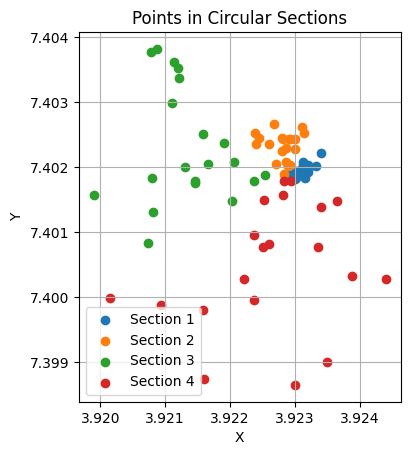

In [106]:
# # Parameters
# distance = neighbor_distances / 2  # Maximum distance from the center
# num_points_per_section = 20  # Number of points to generate per section

# # Generate points in circular sections
# section_points = generate_points_in_circle_sections(section_angles, neighbor_distances, num_points_per_section, centeroid_pointer)

# # Scatter plot for each section
# fig, ax = plt.subplots()
# for section_index, points in enumerate(section_points):
#     ax.scatter(points[:, 0], points[:, 1], label=f"Section {section_index+1}")

# ax.set_aspect('equal', 'box')
# ax.legend()
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Points in Circular Sections')
# plt.grid(True)
# plt.show()


In [133]:
def data_generator_pipeline(knn_func, longitudes, latitudes, labels, ceteroid_pointer):

    distances, indices = calculate_knn(knn_function = knn_func, longitude = centeroid_pointer[0], latitude=centeroid_pointer[0])

    neighbor_distances, neighbor_indices = neighbor_distance(distances, indices)
    # print(f'neighbor_distance {neighbor_distances}, neighbor_indices {neighbor_indices}')

    neiboring_coordinates = extracting_pointer(longitudes, latitudes, labels)
    # print(f'neighboring_coordinate {neiboring_coordinates}')

    grouped_center_neighborhood = group_neighbor_pointers(neiboring_coordinates, labels, centeroid_pointer)
    # print(f'grouped_center_neighborhood: {grouped_center_neighborhood}')

    sorted_cng = sort_angle_based(grouped_center_neighborhood)
    # print(f'sorted_cng: {sorted_cng}')

    section_angles = calculate_angle_section(sorted_cng)
    # print(f'section_angles: {section_angles}')

    # This part will be part of the loop as well. 

    # Parameters
    distance = neighbor_distances / 2  # Maximum distance from the center
    num_points_per_section = 20  # Number of points to generate per section

    # Generate points in circular sections
    section_points = generate_points_in_circle_sections(section_angles, neighbor_distances, num_points_per_section, centeroid_pointer)
    return section_points
        

In [140]:
knn_func = knn_function(longitudes, latitudes) # passing the list of longitudes and latitudes
centeroid = [longitudes[0], latitudes[0]]
section_points = data_generator_pipeline(knn_func, longitudes, latitudes, labels, centeroid)


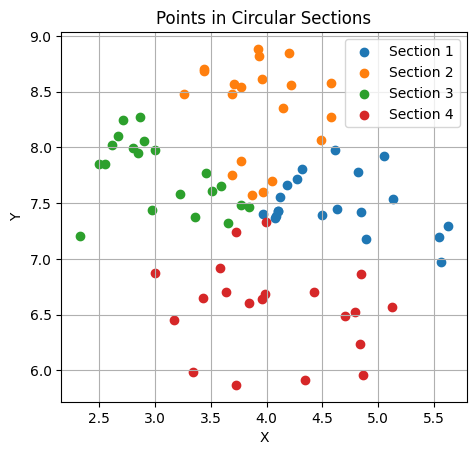

In [141]:
# Scatter plot for each section
fig, ax = plt.subplots()
for section_index, points in enumerate(section_points):
    ax.scatter(points[:, 0], points[:, 1], label=f"Section {section_index+1}")

ax.set_aspect('equal', 'box')
ax.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Points in Circular Sections')
plt.grid(True)
plt.show()


In [ ]:
def data_preprocessing_pipeline(df): # dataframe or the path to the dataframe
    # the 
    pass


In [147]:
def main_pipeline(longitudes, latitudes, labels):
    knn_func = knn_function(longitudes, latitudes) # passing the list of longitudes and latitudes

    data_points = [] # list of all the coordinates

    for long, lat, lab in zip(longitudes, latitudes, labels):
        centroid = [long, lat, lab]
        section_points = data_generator_pipeline(knn_func, longitudes, latitudes, labels, centeroid)

        for section in section_points:
            for angle_site in section:
                data_points.append([angle_site[0], angle_site[1], centroid[2]])

        data_points.append(centroid)

    return data_points


In [151]:
len(longitudes)


85

In [148]:
data_result = main_pipeline(longitudes, latitudes, labels)
len(data_result)


6885

In [149]:
columns = ['Longitude', 'Latitude', 'Settlement']
genratedData = pd.DataFrame(data_result, columns = columns)


In [150]:
def df_to_json(df, settings, additional_features = False):
    """
    Convert a DataFrame with longitude and latitude columns to a JSON format with specified structure.
    
    Parameters:
    - df: DataFrame containing the data
    - setting: include all the feature that need to be included. 
    - polygon: polygon the polygon shape that needs to be created based on the given latitude and longitude
    
    Returns:
    - JSON formatted data
    """
    features = []
    coordinates = settings['extracted_features']
    properties = settings['properties_to_include']
    sparcity = settings['distance']
    additional_feature_items = settings["class_specification"]
    
    for _, row in df.iterrows():
        # Extract longitude and latitude
        lon = row[coordinates[0]]
        lat = row[coordinates[1]]
        
        # Create properties dictionary
        # Extract longitude and latitude
        lon = row[coordinates[0]]
        lat = row[coordinates[1]]
        
        # Create properties dictionary
        if properties:
            props = {prop: row[prop] for prop in properties}
            if additional_features:
                for k, v in additional_feature_items.items():
                    if k == "marker-color":
                        # print(row['Settlement'])
                        props[k] = v[(row['Settlement'])]
                    else:
                        props[k] = v
                        

        else:
            props = {}
        
        # Add longitude and latitude to properties
        props[coordinates[0]] = lon
        props[coordinates[1]] = lat
        if settings['shape_type'] == 'Polygon' or settings['shape_type'] == 'Both': 
            # shape = [generate_rectangle(lon, lat, sparcity['width'], sparcity['height'])]
            # Create GeoJSON feature
            feature = {
                "type": "Feature",
                "properties": props,
                "geometry": {
                    "type": "Polygon",
                    "coordinates": shape
                }
            }
            features.append(feature)
        if settings['shape_type'] == "Point" or settings['shape_type'] == 'Both': 
            shape = [lon, lat]
            feature = {
                "type": "Feature",
                "properties": props,
                "geometry": {
                    "type": "Point",
                    "coordinates": shape
                }
            }


            features.append(feature)
    
    # Create FeatureCollection
    feature_collection = {
        "type": "FeatureCollection",
        "features": features
    }
    
    return feature_collection

# Example usage:
# Assuming your DataFrame is named 'df' and contains columns: city, ward, ea_code, EAS, Longitude, Latitude, Settlement, geometry
# And you want to include city, ward, ea_code, EAS, Settlement in the properties
additional_features = {
        "marker-size": 'small',
        "marker-color": {
                0 : "#FF0000",
                1 : "#00FF00",
                2 : "#0000FF"
        },
        "marker-symbol": 'circle'
    }

settings = {
    "properties_to_include" : ['Settlement'],
    'extracted_features' : ['Longitude', 'Latitude'],
    "distance" : {'width' : 50, 'height': 50}, # Width and height are messured in miters. 
    'shape_type' : 'Point', # Polygone, Point, Both
    "class_specification" : additional_features
}

json_data = df_to_json(genratedData, settings, additional_features = True)

# Save JSON to a file
with open('Ibadan_Bashorun_AOI_GeneratedPointers_angle_v1.json', 'w') as f:
    json.dump(json_data, f)
